# Drugs Molecules 3D Structure Analysis Using logP Prediction

## Introduction

Lipophilicity, quantified by the partition coefficient (logP), represents the differential solubility of a compound between an aqueous and a lipophilic environment. This fundamental molecular property profoundly influences pharmacokinetic behavior, including absorption, distribution, and membrane permeability.

Traditional computational methods, such as the Crippen fragmentation approach implemented in RDKit, estimate logP through additive atom-type contributions. While computationally efficient, these methods exhibit systematic deviations, particularly for larger molecular structures. This tutorial demonstrates a machine learning approach that learns to correct these baseline predictions through graph neural network representations.

### Learning Objectives

1. Analyze the distribution of molecular properties in the Lipophilicity dataset
2. Evaluate the RDKit baseline performance and identify systematic errors
3. Understand message passing graph neural network architecture for molecular featurization
4. Train a contextual per-atom scalar model to improve logP predictions
5. Interpret model corrections through visualization of per-atom contributions

### Dataset

This tutorial utilizes the Lipophilicity dataset from DeepChem, comprising 4,200 molecules with experimental logP measurements. The dataset spans a diverse range of molecular weights and structural motifs, providing comprehensive coverage of drug-like chemical space.

In [1]:
# Import required libraries
import sys
from pathlib import Path

# Add project root to Python path to enable imports from src module
project_root = Path.cwd().parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Configure academic plotting style
plt.style.use('seaborn-v0_8-paper')
sns.set_palette("colorblind")

# Set random seeds for reproducibility
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# Suppress warnings for cleaner output
import warnings
warnings.filterwarnings('ignore')

print("Environment configured successfully.")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
print(f"Project root: {project_root}")

Environment configured successfully.
PyTorch version: 2.7.0
CUDA available: False
Project root: /Users/ofirsimhi/GitHub


## Section 1: Dataset Analysis

### Overview

We begin by examining the distribution of molecular properties in the dataset. Understanding these distributions is critical for assessing model generalization and identifying potential biases in the training data. We analyze both the complete dataset and the individual train/validation/test splits to ensure statistical comparability.

In [2]:
from src.utils.data import get_dataset

# Load the complete dataset
df = get_dataset()

# Display dataset statistics
print("Dataset Statistics")
print("=" * 60)
print(f"Total molecules: {len(df)}")
print(f"\nExperimental logP statistics:")
print(f"  Mean: {df['exp'].mean():.3f}")
print(f"  Std:  {df['exp'].std():.3f}")
print(f"  Min:  {df['exp'].min():.3f}")
print(f"  Max:  {df['exp'].max():.3f}")

# Display first few molecules
print("\nSample molecules:")
df.head()

Dataset Statistics
Total molecules: 13962

Experimental logP statistics:
  Mean: 2.077
  Std:  1.833
  Min:  -5.080
  Max:  11.290

Sample molecules:


,ChemID,CAS,smiles,preferred_name,dsstox_substance_id,dsstox_compound_id,Canonical_QSARr,InChI_Code_QSARr,InChI Key_QSARr,Salt_Solvent,Salt_Solvent_ID,MPID,Kow Reference,exp,Tr_1_Tst_0,ID
0,100001,50-00-0,C=O,Formaldehyde,DTXSID7020637,DTXCID30637,C=O,InChI=1S/CH2O/c1-2/h1H2,WSFSSNUMVMOOMR-UHFFFAOYSA-N,NaN,0,4675,"HANSCH,C ET AL. (1995)",0.35,1.0,Row0
1,100002,50-02-2|378-44-9,C[C@@H]1C[C@H]2[C@@H]3CCC4=CC(=O)C=C[C@]4(C)[C...,Dexamethasone|Betamethasone,DTXSID3020384|DTXSID3022667,DTXCID10384|DTXCID002667,CC1CC2C3CCC4=CC(=O)C=CC4(C)C3(F)C(O)CC2(C)C1(O...,InChI=1S/C22H29FO5/c1-12-8-16-15-5-4-13-9-14(2...,UREBDLICKHMUKA-UHFFFAOYSA-N,NaN,0,4676|6480|363694|363716,"HANSCH,C ET AL. (1995)|?",1.92,1.0,Row1
2,100003,50-03-3,CC(=O)OCC(=O)[C@@]1(O)CCC2C3CCC4=CC(=O)CC[C@]4...,Hydrocortisone acetate,DTXSID0048686,DTXCID0028612,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,InChI=1S/C23H32O6/c1-13(24)29-12-19(27)23(28)9...,ALEXXDVDDISNDU-UHFFFAOYSA-N,NaN,0,4677,"HANSCH,C ET AL. (1995)",2.19,1.0,Row2
3,100004,50-04-4,CC(=O)OCC(=O)[C@@]1(O)CC[C@H]2[C@@H]3CCC4=CC(=...,Cortisone acetate,DTXSID0022858,DTXCID502858,CC(=O)OCC(=O)C1(O)CCC2C3CCC4=CC(=O)CCC4(C)C3C(...,InChI=1S/C23H30O6/c1-13(24)29-12-19(27)23(28)9...,ITRJWOMZKQRYTA-UHFFFAOYSA-N,NaN,0,4678|363670,"HANSCH,C ET AL. (1995)|?",2.10,1.0,Row3
4,100005,50-06-6,CCC1(c2ccccc2)C(=O)NC(=O)NC1=O,Phenobarbital,DTXSID5021122,DTXCID701122,CCC1(C2C=CC=CC=2)C(=O)NC(=O)NC1=O,InChI=1S/C12H12N2O3/c1-2-12(8-6-4-3-5-7-8)9(15...,DDBREPKUVSBGFI-UHFFFAOYSA-N,NaN,0,4679,"HANSCH,C ET AL. (1995)",1.47,0.0,Row4


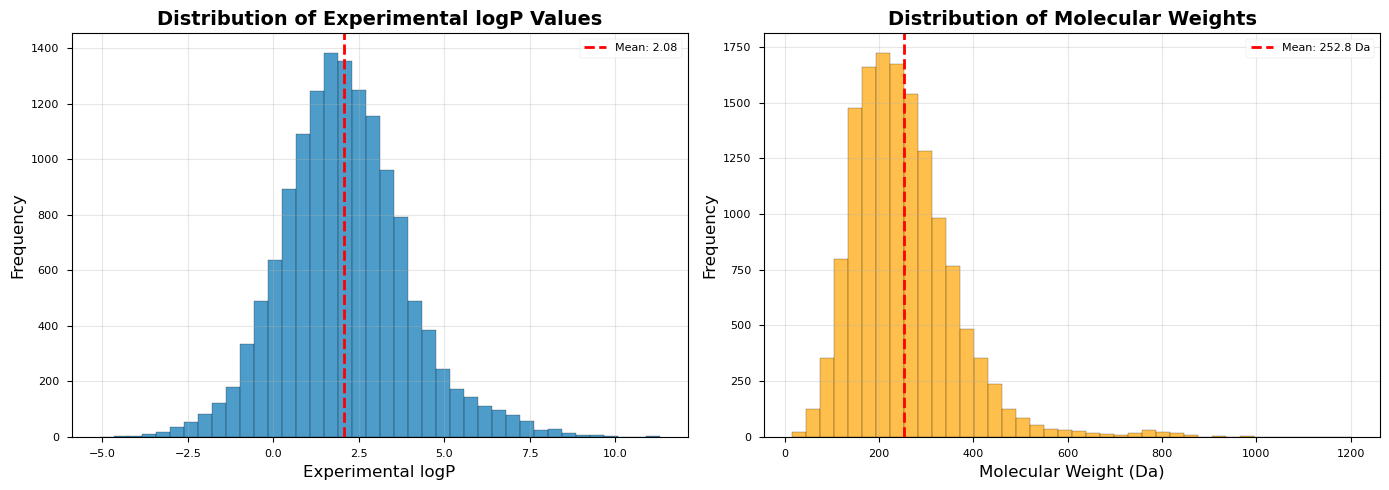

In [3]:
# Visualize original dataset distributions
from src.utils.data import get_features_and_targets


fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LogP distribution
axes[0].hist(df['exp'], bins=40, edgecolor='black', alpha=0.7)
axes[0].axvline(df['exp'].mean(), color='red', linestyle='--', linewidth=2, label=f'Mean: {df["exp"].mean():.2f}')
axes[0].set_xlabel('Experimental logP', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('Distribution of Experimental logP Values', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Load processed data to get molecular weights
X_atom_fps, atom_rdkit_score, mol_indexs, mol_data = get_features_and_targets(df)

mws = [mol['mw'] for mol in mol_data]
exp_logps = [mol['exp_logp'] for mol in mol_data]

# Molecular weight distribution
axes[1].hist(mws, bins=40, edgecolor='black', alpha=0.7, color='orange')
axes[1].axvline(np.mean(mws), color='red', linestyle='--', linewidth=2, label=f'Mean: {np.mean(mws):.1f} Da')
axes[1].set_xlabel('Molecular Weight (Da)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Distribution of Molecular Weights', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)


plt.tight_layout()
plt.show()


In [4]:
from src.utils.data import create_and_save_splits

create_and_save_splits(mol_indexs=mol_indexs, mol_data=mol_data)

# Load split data
train_df = pd.read_csv('data/splits/train.csv')
val_df = pd.read_csv('data/splits/val.csv')
test_df = pd.read_csv('data/splits/test.csv')

print("Data Split Statistics")
print("=" * 60)
print(f"Train set: {len(train_df)} molecules ({len(train_df)/len(mol_data)*100:.1f}%)")
print(f"Val set:   {len(val_df)} molecules ({len(val_df)/len(mol_data)*100:.1f}%)")
print(f"Test set:  {len(test_df)} molecules ({len(test_df)/len(mol_data)*100:.1f}%)")
print(f"Total:     {len(train_df) + len(val_df) + len(test_df)} molecules")

Data Split Statistics
Train set: 10051 molecules (72.0%)
Val set:   1117 molecules (8.0%)
Test set:  2793 molecules (20.0%)
Total:     13961 molecules


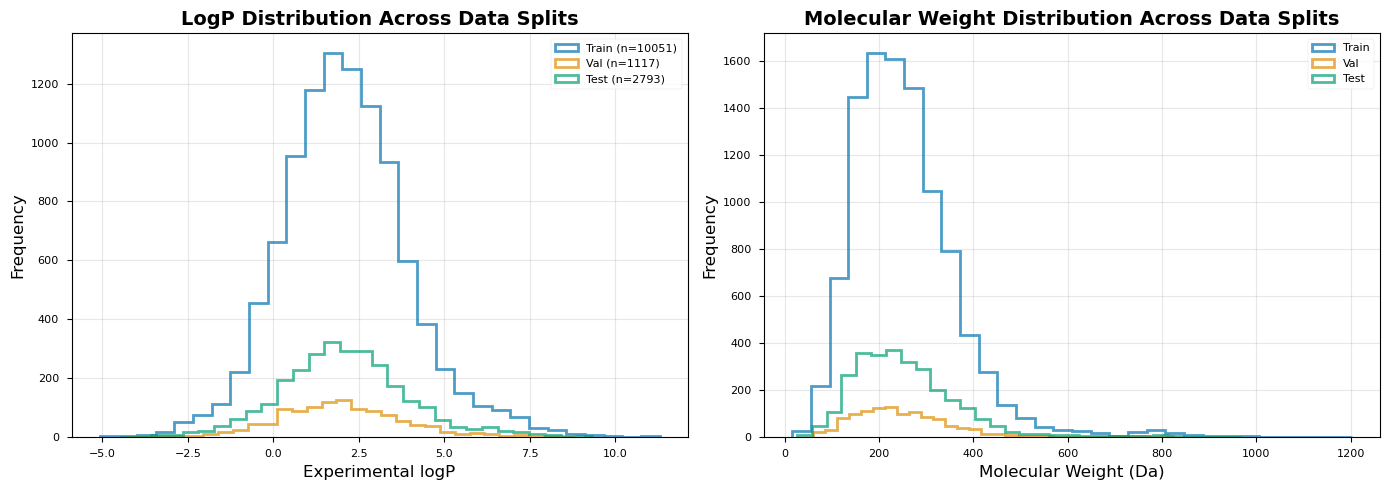


Statistical Comparison of Splits
Split      | LogP Mean    | LogP Std     | MW Mean     
------------------------------------------------------------
Train      | 2.089        | 1.830        | 253.4       
Val        | 1.983        | 1.811        | 248.2       
Test       | 2.070        | 1.854        | 252.5       


In [5]:
# Visualize split distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# LogP distribution by split
axes[0].hist(train_df['exp_logp'], bins=30, alpha=0.7, histtype='step', linewidth=2, 
             label=f'Train (n={len(train_df)})', edgecolor='C0')
axes[0].hist(val_df['exp_logp'], bins=30, alpha=0.7, histtype='step', linewidth=2, 
             label=f'Val (n={len(val_df)})', edgecolor='C1')
axes[0].hist(test_df['exp_logp'], bins=30, alpha=0.7, histtype='step', linewidth=2, 
             label=f'Test (n={len(test_df)})', edgecolor='C2')
axes[0].set_xlabel('Experimental logP', fontsize=12)
axes[0].set_ylabel('Frequency', fontsize=12)
axes[0].set_title('LogP Distribution Across Data Splits', fontsize=14, fontweight='bold')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Molecular weight distribution by split
axes[1].hist(train_df['mw'], bins=30, alpha=0.7, histtype='step', linewidth=2, 
             label=f'Train', edgecolor='C0')
axes[1].hist(val_df['mw'], bins=30, alpha=0.7, histtype='step', linewidth=2, 
             label=f'Val', edgecolor='C1')
axes[1].hist(test_df['mw'], bins=30, alpha=0.7, histtype='step', linewidth=2, 
             label=f'Test', edgecolor='C2')
axes[1].set_xlabel('Molecular Weight (Da)', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].set_title('Molecular Weight Distribution Across Data Splits', fontsize=14, fontweight='bold')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Statistical comparison
print("\nStatistical Comparison of Splits")
print("=" * 60)
print(f"{'Split':<10} | {'LogP Mean':<12} | {'LogP Std':<12} | {'MW Mean':<12}")
print("-" * 60)
print(f"{'Train':<10} | {train_df['exp_logp'].mean():<12.3f} | {train_df['exp_logp'].std():<12.3f} | {train_df['mw'].mean():<12.1f}")
print(f"{'Val':<10} | {val_df['exp_logp'].mean():<12.3f} | {val_df['exp_logp'].std():<12.3f} | {val_df['mw'].mean():<12.1f}")
print(f"{'Test':<10} | {test_df['exp_logp'].mean():<12.3f} | {test_df['exp_logp'].std():<12.3f} | {test_df['mw'].mean():<12.1f}")

### Analysis Interpretation

The distributions demonstrate that the data splits maintain statistical similarity across all measured properties. The experimental logP values follow an approximately normal distribution centered near 2.5, consistent with drug-like molecules. Molecular weights range from small fragments to moderately large drug molecules, with a mean around 300-350 Da.

The weak positive correlation between molecular weight and logP reflects the general trend that larger molecules tend to be more lipophilic, though substantial variance exists due to the influence of polar functional groups.

## Section 2: RDKit Baseline Evaluation

### RDKit Crippen Method

The Crippen fragmentation approach partitions molecules into predefined atom types and assigns each type a contribution to logP. The total predicted logP is calculated as the sum of individual atom contributions. While this method provides rapid estimates, it inherently assumes additivity and neglects conformational effects and intramolecular interactions.

We evaluate the baseline performance on the test set to establish a reference point for our learned model. The comprehensive visualizations utilize all available data (train, validation, and test sets) to identify systematic biases that machine learning might correct.

In [6]:
# Calculate baseline errors on test set
test_exp = test_df['exp_logp'].values
test_rdkit = test_df['rdkit_logp'].values
test_mw = test_df['mw'].values

rmse_baseline = np.sqrt(mean_squared_error(test_exp, test_rdkit))
mae_baseline = mean_absolute_error(test_exp, test_rdkit)

print("RDKit Baseline Performance on Test Set")
print("=" * 60)
print(f"Root Mean Square Error (RMSE): {rmse_baseline:.4f}")
print(f"Mean Absolute Error (MAE):     {mae_baseline:.4f}")
print(f"\nNumber of test molecules:      {len(test_exp)}")
print("\nNote: Subsequent visualizations will use all data (train+val+test)")
print("to provide a comprehensive view of baseline performance.")

RDKit Baseline Performance on Test Set
Root Mean Square Error (RMSE): 2.0893
Mean Absolute Error (MAE):     1.7294

Number of test molecules:      2793

Note: Subsequent visualizations will use all data (train+val+test)
to provide a comprehensive view of baseline performance.


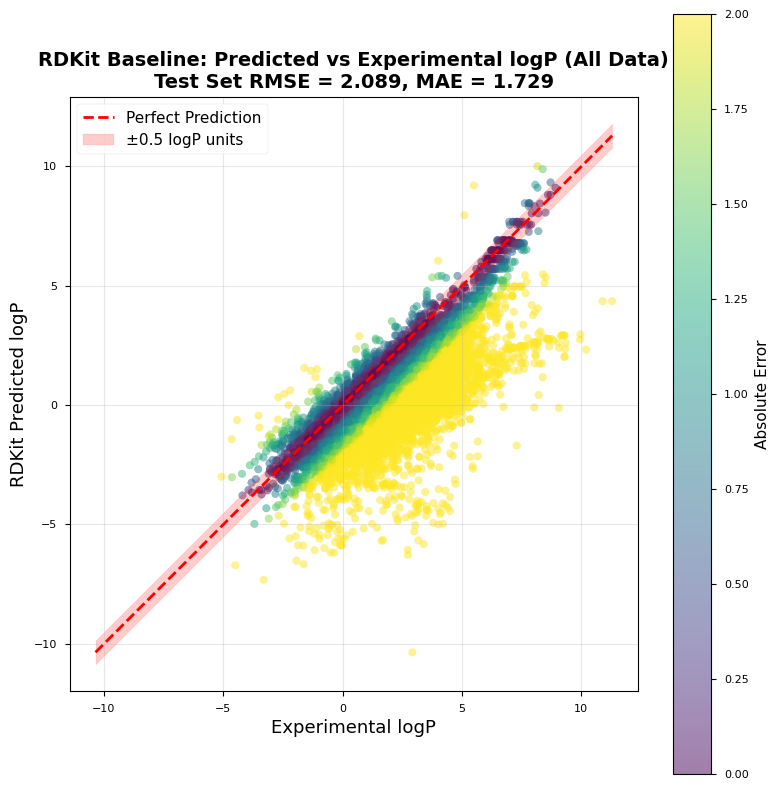


Visualization includes 13961 molecules from all splits


In [7]:
# Baseline prediction vs ground truth visualization (using all data)
# Combine all splits for comprehensive baseline visualization
all_exp = np.concatenate([train_df['exp_logp'].values, val_df['exp_logp'].values, test_df['exp_logp'].values])
all_rdkit = np.concatenate([train_df['rdkit_logp'].values, val_df['rdkit_logp'].values, test_df['rdkit_logp'].values])
all_mw = np.concatenate([train_df['mw'].values, val_df['mw'].values, test_df['mw'].values])

fig, ax = plt.subplots(1, 1, figsize=(8, 8))

# Scatter plot
scatter = ax.scatter(all_exp, all_rdkit, alpha=0.5, s=30, c=np.abs(all_exp - all_rdkit), 
                     cmap='viridis', vmin=0, vmax=2)

# Identity line
min_val = min(all_exp.min(), all_rdkit.min())
max_val = max(all_exp.max(), all_rdkit.max())
ax.plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')

# Error bands
ax.fill_between([min_val, max_val], [min_val - 0.5, max_val - 0.5], 
                 [min_val + 0.5, max_val + 0.5], alpha=0.2, color='red', label='±0.5 logP units')

ax.set_xlabel('Experimental logP', fontsize=13)
ax.set_ylabel('RDKit Predicted logP', fontsize=13)
ax.set_title(f'RDKit Baseline: Predicted vs Experimental logP (All Data)\nTest Set RMSE = {rmse_baseline:.3f}, MAE = {mae_baseline:.3f}', 
             fontsize=14, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
ax.set_aspect('equal', adjustable='box')

# Add colorbar
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Absolute Error', fontsize=11)

plt.tight_layout()
plt.show()

print(f"\nVisualization includes {len(all_exp)} molecules from all splits")

# Store for next analysis
all_abs_errors = np.abs(all_exp - all_rdkit)

Calculating molecular descriptors for correlation analysis...
After removing 5% outliers: 13263/13961 molecules retained

Correlation Analysis: Molecular Features vs Prediction Error
(Excluding top and bottom 2.5% error outliers)
Feature                         Abs Error r  Signed Error r
----------------------------------------------------------------------
Num H-Bond Acceptors                 0.2416         -0.2243
Fraction sp³ Carbons                 0.3269         -0.3003
Heavy Atoms                          0.4509         -0.4223

Mean signed error: -1.5911
(Negative = RDKit underpredicts, Positive = RDKit overpredicts)


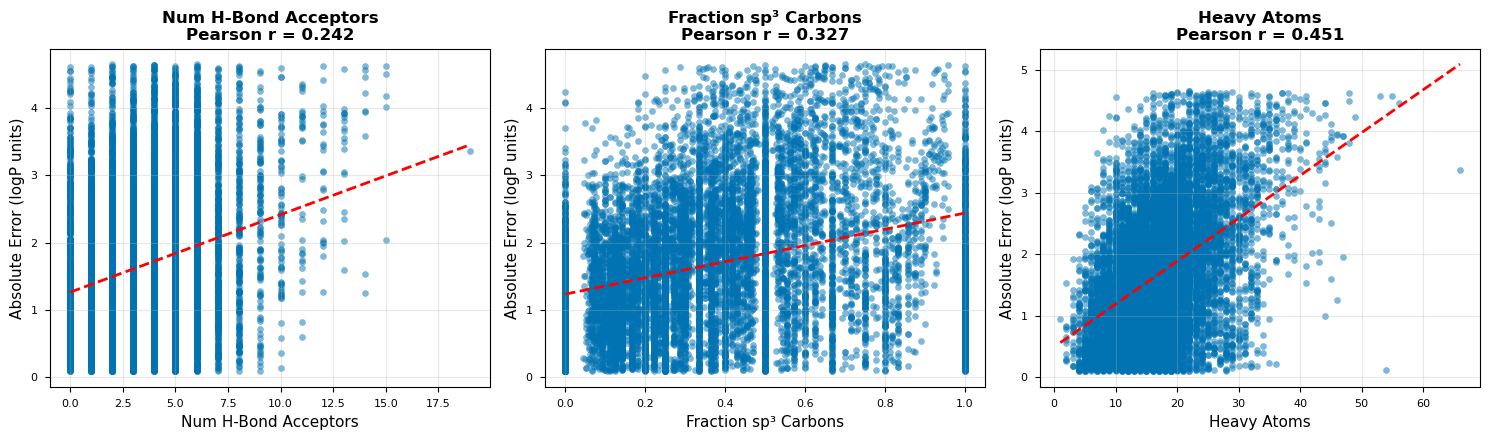


Key Finding: These features correlate with larger absolute errors,
indicating systematic challenges for the RDKit baseline method.


In [8]:
# Calculate molecular descriptors for correlation analysis
from rdkit import Chem
from rdkit.Chem import rdMolDescriptors, Lipinski
from scipy.stats import pearsonr

# Combine SMILES from all splits
all_smiles = np.concatenate([train_df['smiles'].values, val_df['smiles'].values, test_df['smiles'].values])

# Calculate SIGNED errors (RDKit - Experimental)
# Positive = RDKit overpredicts (too high/lipophilic)
# Negative = RDKit underpredicts (too low/hydrophilic)
all_signed_errors = all_rdkit - all_exp

# Calculate features for all molecules
print("Calculating molecular descriptors for correlation analysis...")
num_h_acceptors = []
fraction_csp3 = []
heavy_atoms = []

for smiles in all_smiles:
    mol = Chem.MolFromSmiles(smiles)
    if mol is not None:
        num_h_acceptors.append(rdMolDescriptors.CalcNumHBA(mol))
        fraction_csp3.append(rdMolDescriptors.CalcFractionCSP3(mol))
        heavy_atoms.append(mol.GetNumHeavyAtoms())
    else:
        # Handle invalid SMILES (shouldn't happen)
        num_h_acceptors.append(0)
        fraction_csp3.append(0)
        heavy_atoms.append(0)

# Convert to numpy arrays
num_h_acceptors = np.array(num_h_acceptors)
fraction_csp3 = np.array(fraction_csp3)
heavy_atoms = np.array(heavy_atoms)

# Remove 5% outliers (top and bottom 2.5%) based on absolute error
lower_percentile = np.percentile(all_abs_errors, 2.5)
upper_percentile = np.percentile(all_abs_errors, 97.5)
mask_inliers = (all_abs_errors >= lower_percentile) & (all_abs_errors <= upper_percentile)

# Filter data
errors_filtered = all_abs_errors[mask_inliers]
signed_errors_filtered = all_signed_errors[mask_inliers]
h_acceptors_filtered = num_h_acceptors[mask_inliers]
csp3_filtered = fraction_csp3[mask_inliers]
heavy_filtered = heavy_atoms[mask_inliers]

print(f"After removing 5% outliers: {sum(mask_inliers)}/{len(all_abs_errors)} molecules retained")

# Calculate correlations on filtered data (both absolute and signed)
corr_h_abs, p_h_abs = pearsonr(h_acceptors_filtered, errors_filtered)
corr_h_signed, p_h_signed = pearsonr(h_acceptors_filtered, signed_errors_filtered)

corr_csp3_abs, p_csp3_abs = pearsonr(csp3_filtered, errors_filtered)
corr_csp3_signed, p_csp3_signed = pearsonr(csp3_filtered, signed_errors_filtered)

corr_heavy_abs, p_heavy_abs = pearsonr(heavy_filtered, errors_filtered)
corr_heavy_signed, p_heavy_signed = pearsonr(heavy_filtered, signed_errors_filtered)

# Display correlation statistics
print("\nCorrelation Analysis: Molecular Features vs Prediction Error")
print("(Excluding top and bottom 2.5% error outliers)")
print("=" * 70)
print(f"{'Feature':<30} {'Abs Error r':>12} {'Signed Error r':>15}")
print("-" * 70)
print(f"{'Num H-Bond Acceptors':<30} {corr_h_abs:>12.4f} {corr_h_signed:>15.4f}")
print(f"{'Fraction sp³ Carbons':<30} {corr_csp3_abs:>12.4f} {corr_csp3_signed:>15.4f}")
print(f"{'Heavy Atoms':<30} {corr_heavy_abs:>12.4f} {corr_heavy_signed:>15.4f}")
print("=" * 70)
print(f"\nMean signed error: {signed_errors_filtered.mean():.4f}")
print("(Negative = RDKit underpredicts, Positive = RDKit overpredicts)")

# Create visualization using filtered data (absolute errors)
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

features = [
    (h_acceptors_filtered, 'Num H-Bond Acceptors', corr_h_abs),
    (csp3_filtered, 'Fraction sp³ Carbons', corr_csp3_abs),
    (heavy_filtered, 'Heavy Atoms', corr_heavy_abs)
]

for idx, (feature_data, feature_name, corr_val) in enumerate(features):
    ax = axes[idx]

    # Scatter plot
    ax.scatter(feature_data, errors_filtered, alpha=0.5, s=20)

    # Trend line
    z = np.polyfit(feature_data, errors_filtered, 1)
    p = np.poly1d(z)
    x_range = np.linspace(feature_data.min(), feature_data.max(), 100)
    ax.plot(x_range, p(x_range), 'r--', linewidth=2)

    ax.set_xlabel(feature_name, fontsize=11)
    ax.set_ylabel('Absolute Error (logP units)', fontsize=11)
    ax.set_title(f'{feature_name}\nPearson r = {corr_val:.3f}',
                 fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nKey Finding: These features correlate with larger absolute errors,")
print(f"indicating systematic challenges for the RDKit baseline method.")

### Error Direction Analysis

Beyond correlation magnitude, examining the **direction** of prediction errors reveals systematic biases in the RDKit baseline method. By analyzing signed errors (RDKit prediction minus experimental value), we can determine whether the baseline systematically over-predicts or under-predicts logP for molecules with specific structural features.

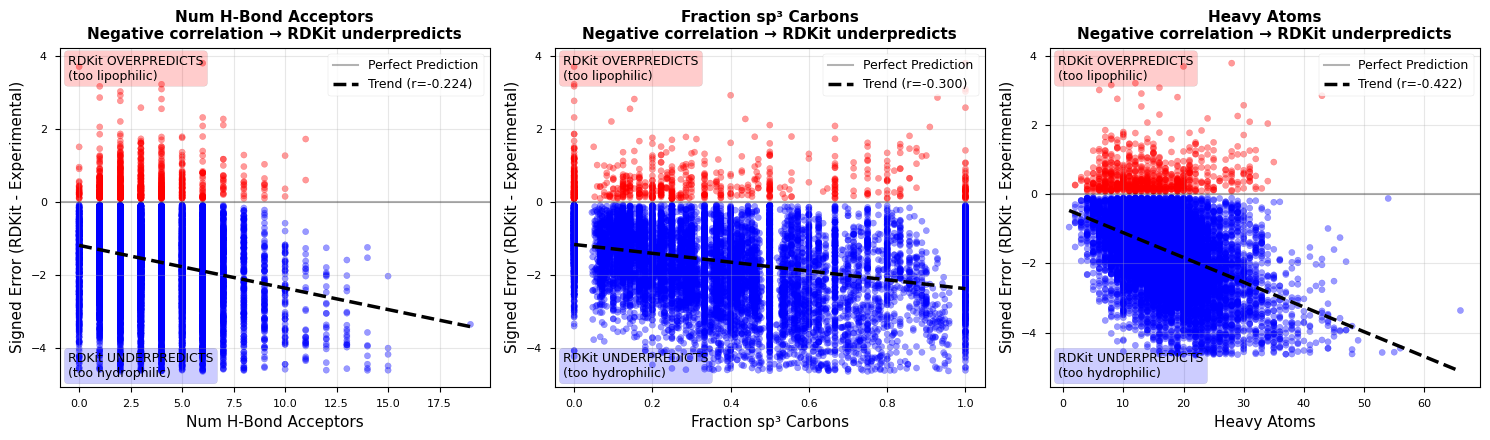


Critical Finding: SYSTEMATIC UNDERPREDICTION BIAS
RDKit baseline systematically UNDERPREDICTS logP (predicts too low) for:
  • Molecules with many H-bond acceptors (r = -0.224)
  • Molecules with high sp³ carbon content (r = -0.300)
  • Larger molecules (r = -0.422)

Interpretation:
  RDKit's additive fragmentation method overestimates the hydrophilic
  contribution of polar groups and underestimates the hydrophobic effect
  in saturated, flexible molecules. The machine learning correction model
  addresses this by learning context-dependent adjustments.


In [9]:
# Visualize ERROR DIRECTION: Signed Error vs Molecular Features
fig, axes = plt.subplots(1, 3, figsize=(15, 4.5))

features_signed = [
    (h_acceptors_filtered, 'Num H-Bond Acceptors', corr_h_signed),
    (csp3_filtered, 'Fraction sp³ Carbons', corr_csp3_signed),
    (heavy_filtered, 'Heavy Atoms', corr_heavy_signed)
]

for idx, (feature_data, feature_name, corr_val) in enumerate(features_signed):
    ax = axes[idx]
    
    # Scatter plot with color coding
    colors = ['red' if e > 0 else 'blue' for e in signed_errors_filtered]
    ax.scatter(feature_data, signed_errors_filtered, alpha=0.4, s=20, c=colors)
    
    # Zero line (perfect prediction)
    ax.axhline(y=0, color='black', linestyle='-', linewidth=1.5, alpha=0.3, label='Perfect Prediction')
    
    # Trend line
    z = np.polyfit(feature_data, signed_errors_filtered, 1)
    p = np.poly1d(z)
    x_range = np.linspace(feature_data.min(), feature_data.max(), 100)
    ax.plot(x_range, p(x_range), 'k--', linewidth=2.5, label=f'Trend (r={corr_val:.3f})')
    
    ax.set_xlabel(feature_name, fontsize=11)
    ax.set_ylabel('Signed Error (RDKit - Experimental)', fontsize=11)
    ax.set_title(f'{feature_name}\nNegative correlation → RDKit underpredicts',
                 fontsize=11, fontweight='bold')
    ax.grid(True, alpha=0.3)
    ax.legend(fontsize=9, loc='upper right')
    
    # Add text annotation
    ax.text(0.02, 0.98, 'RDKit OVERPREDICTS\n(too lipophilic)', 
            transform=ax.transAxes, fontsize=9, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='red', alpha=0.2))
    ax.text(0.02, 0.02, 'RDKit UNDERPREDICTS\n(too hydrophilic)', 
            transform=ax.transAxes, fontsize=9, verticalalignment='bottom',
            bbox=dict(boxstyle='round', facecolor='blue', alpha=0.2))

plt.tight_layout()
plt.show()

print("\nCritical Finding: SYSTEMATIC UNDERPREDICTION BIAS")
print("=" * 70)
print("RDKit baseline systematically UNDERPREDICTS logP (predicts too low) for:")
print(f"  • Molecules with many H-bond acceptors (r = {corr_h_signed:.3f})")
print(f"  • Molecules with high sp³ carbon content (r = {corr_csp3_signed:.3f})")
print(f"  • Larger molecules (r = {corr_heavy_signed:.3f})")
print("\nInterpretation:")
print("  RDKit's additive fragmentation method overestimates the hydrophilic")
print("  contribution of polar groups and underestimates the hydrophobic effect")
print("  in saturated, flexible molecules. The machine learning correction model")
print("  addresses this by learning context-dependent adjustments.")

### Baseline Limitations

The analysis of the complete dataset reveals a systematic dependency of prediction error on molecular size. Larger molecules exhibit greater absolute errors, suggesting that the additive fragmentation model inadequately captures the complexity of intramolecular interactions in extended structures.

The positive correlation between molecular weight and prediction error is consistent across all data splits, indicating this is a fundamental limitation of the Crippen method rather than a dataset-specific artifact. This observation motivates the development of a learned correction model that can adapt to molecular context and potentially reduce these systematic biases.

## Section 3: Message Passing Graph Neural Network

### Graph Representation of Molecules

Graph Neural Networks (GNNs) provide a natural framework for molecular property prediction by representing molecules as mathematical graphs where atoms correspond to nodes and chemical bonds correspond to edges. This representation preserves the topological structure and enables learning of spatial relationships.

### Message Passing Algorithm

The message passing neural network iteratively updates node representations by aggregating information from neighboring nodes. In our implementation, we perform three rounds of message passing, allowing each atom to gather information from neighbors up to three bonds away. This captures local chemical environment without introducing learnable parameters.

In [10]:
# Import graph neural network components
from rdkit import Chem
from rdkit.Chem import Draw
from src.mp_graph.featurizer import Featurizer
from src.mp_graph.mp_graph import MessagePassingGraph

print("Graph neural network components imported successfully.")

Graph neural network components imported successfully.


### Molecular Featurization

Each atom is characterized by a 40-dimensional feature vector encoding:
- **Atom type** (10 categories): C, N, O, S, F, Cl, Br, I, P, or Other
- **Degree** (6 categories): 0-5 bonded neighbors
- **Formal charge** (5 categories): -2, -1, 0, +1, +2
- **Hybridization** (6 categories): SP, SP², SP³, SP³D, SP³D², or Unspecified
- **Aromaticity** (binary): Aromatic or non-aromatic
- **Hydrogen count** (5 categories): 0-4 attached hydrogens
- **Valence** (7 categories): 0-6 total valence

Chemical bonds are characterized by a 10-dimensional feature vector encoding bond type, conjugation, ring membership, and stereochemistry.

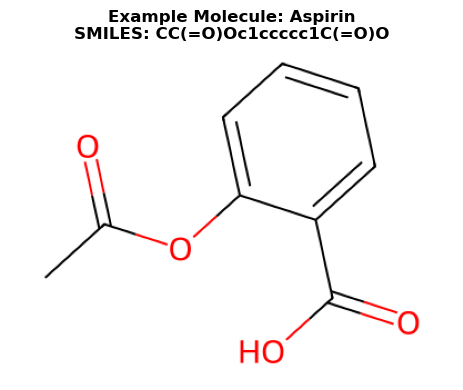

Molecular formula: C9H8O4
Number of atoms: 13
Number of bonds: 13


In [11]:
# Demonstrate featurization on example molecule (Aspirin)
example_smiles = "CC(=O)Oc1ccccc1C(=O)O"
mol = Chem.MolFromSmiles(example_smiles)

# Display molecular structure
img = Draw.MolToImage(mol, size=(400, 300))
plt.figure(figsize=(6, 4))
plt.imshow(img)
plt.axis('off')
plt.title(f"Example Molecule: Aspirin\nSMILES: {example_smiles}", fontsize=12, fontweight='bold')
plt.tight_layout()
plt.show()

print(f"Molecular formula: C9H8O4")
print(f"Number of atoms: {mol.GetNumAtoms()}")
print(f"Number of bonds: {mol.GetNumBonds()}")

In [12]:
# Extract molecular features
featurizer = Featurizer()
atom_features, bond_features, adjacency = featurizer.featurize_molecule(mol)

print("Feature Dimensions")
print("=" * 60)
print(f"Atom features:    {atom_features.shape} (atoms × features)")
print(f"Bond features:    {bond_features.shape} (atoms × atoms × features)")
print(f"Adjacency matrix: {adjacency.shape}")

print(f"\nAtom Feature Breakdown (Total: {featurizer.feature_dim} dimensions)")
print(f"  Atom type:       10 dimensions (one-hot)")
print(f"  Degree:          6 dimensions (one-hot)")
print(f"  Formal charge:   5 dimensions (one-hot)")
print(f"  Hybridization:   6 dimensions (one-hot)")
print(f"  Aromaticity:     1 dimension (binary)")
print(f"  Hydrogen count:  5 dimensions (one-hot)")
print(f"  Valence:         7 dimensions (one-hot)")

print(f"\nBond Feature Breakdown (Total: 10 dimensions)")
print(f"  Bond type:       4 dimensions (one-hot)")
print(f"  Conjugated:      1 dimension (binary)")
print(f"  In ring:         1 dimension (binary)")
print(f"  Stereo:          4 dimensions (one-hot)")

Feature Dimensions
Atom features:    (13, 40) (atoms × features)
Bond features:    (13, 13, 10) (atoms × atoms × features)
Adjacency matrix: (13, 13)

Atom Feature Breakdown (Total: 40 dimensions)
  Atom type:       10 dimensions (one-hot)
  Degree:          6 dimensions (one-hot)
  Formal charge:   5 dimensions (one-hot)
  Hybridization:   6 dimensions (one-hot)
  Aromaticity:     1 dimension (binary)
  Hydrogen count:  5 dimensions (one-hot)
  Valence:         7 dimensions (one-hot)

Bond Feature Breakdown (Total: 10 dimensions)
  Bond type:       4 dimensions (one-hot)
  Conjugated:      1 dimension (binary)
  In ring:         1 dimension (binary)
  Stereo:          4 dimensions (one-hot)


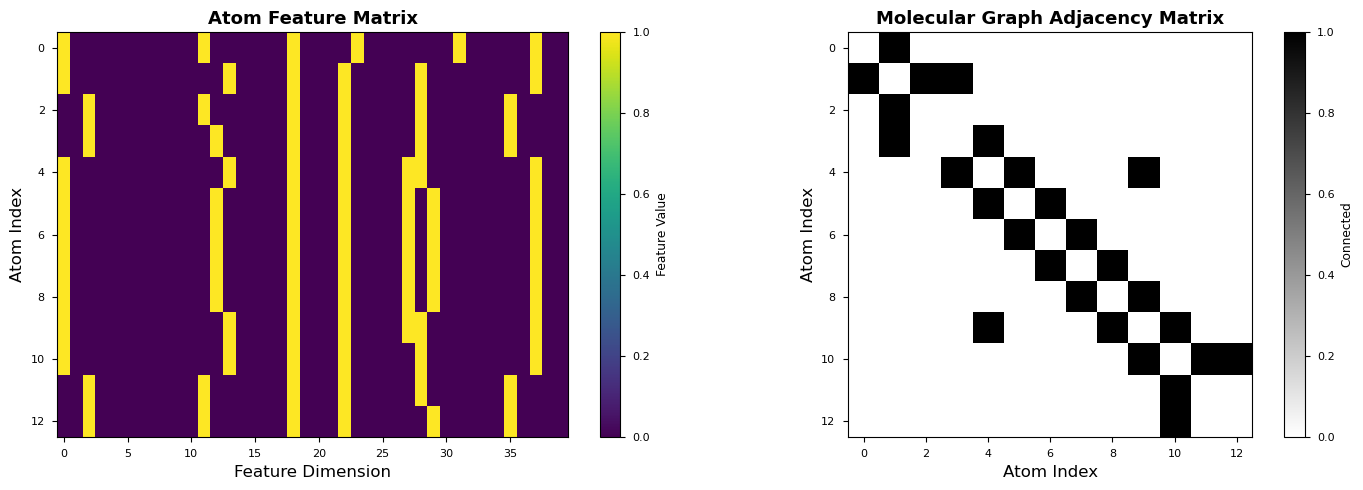

In [13]:
# Visualize feature matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Atom features heatmap
im1 = axes[0].imshow(atom_features, aspect='auto', cmap='viridis')
axes[0].set_xlabel('Feature Dimension', fontsize=12)
axes[0].set_ylabel('Atom Index', fontsize=12)
axes[0].set_title('Atom Feature Matrix', fontsize=13, fontweight='bold')
plt.colorbar(im1, ax=axes[0], label='Feature Value')

# Adjacency matrix
im2 = axes[1].imshow(adjacency, cmap='binary')
axes[1].set_xlabel('Atom Index', fontsize=12)
axes[1].set_ylabel('Atom Index', fontsize=12)
axes[1].set_title('Molecular Graph Adjacency Matrix', fontsize=13, fontweight='bold')
plt.colorbar(im2, ax=axes[1], label='Connected')

plt.tight_layout()
plt.show()

### Message Passing Iterations

The message passing process operates through the following algorithmic steps:

1. **Initialization**: Each atom begins with its featurized representation
2. **Message Construction**: For each bond, a message is computed incorporating source atom features and bond features
3. **Aggregation**: Messages from neighboring atoms are summed to update each atom's representation
4. **Iteration**: Steps 2-3 repeat for *k* rounds (we use *k*=3)

This iterative process allows each atom's final representation to capture information from its local chemical environment extending up to *k* bonds away. Importantly, our implementation does not introduce learnable parameters at this stage; the message passing serves purely as a sophisticated featurization method.

In [14]:
# Perform message passing
mpnn = MessagePassingGraph(depth=3)

# Convert to tensors
atom_feats_t = torch.from_numpy(atom_features)
bond_feats_t = torch.from_numpy(bond_features)
adj_t = torch.from_numpy(adjacency)

# Generate contextualized atom embeddings
atom_embeddings = mpnn(adj_t, atom_feats_t, bond_feats_t, return_atoms=True)

print("Message Passing Results")
print("=" * 60)
print(f"Input shape:  {atom_features.shape}")
print(f"Output shape: {atom_embeddings.shape}")
print(f"\nEach atom now possesses a {atom_embeddings.shape[1]}-dimensional")
print(f"embedding that encodes its local chemical environment.")
print(f"\nAfter 3 message passing rounds, each atom's representation")
print(f"incorporates information from atoms up to 3 bonds away.")

Message Passing Results
Input shape:  (13, 40)
Output shape: torch.Size([13, 40])

Each atom now possesses a 40-dimensional
embedding that encodes its local chemical environment.

After 3 message passing rounds, each atom's representation
incorporates information from atoms up to 3 bonds away.


### Summary

The message passing graph neural network transforms raw molecular structure into rich, contextualized atom representations. Unlike simple SMILES string encoding or molecular fingerprints, this approach:

1. Preserves explicit topological information
2. Captures local chemical environment for each atom
3. Enables differentiation of chemically identical atoms in different contexts
4. Maintains permutation invariance with respect to atom ordering

These embeddings serve as the foundation for our predictive model, which learns to map molecular structure to property corrections.

## Section 4: Model Training

### Model Architecture: Contextual Atom Scalar MLP

Our model learns to predict per-atom scalar multipliers that correct the RDKit baseline logP contributions. The architecture comprises three components:

1. **Atom Encoder**: Maps each atom's message-passed embedding to a latent representation
2. **Molecular Context**: Aggregates all atom representations via mean pooling to capture global molecular properties
3. **Scalar Predictor**: Combines atom-level and molecule-level representations to predict a scalar multiplier for each atom

The predicted logP is calculated as: $\text{logP}_{\text{pred}} = \sum_{i=1}^{N} s_i \cdot c_i^{\text{RDKit}}$

where $s_i$ represents the learned scalar for atom $i$ and $c_i^{\text{RDKit}}$ denotes the RDKit baseline contribution.

In [26]:
# Import training components
from src.mlp_regressor.mlp import ContextualAtomScalarMLP
from src.mlp_regressor.training import train_epoch, evaluate
from src.utils.data import get_dataloaders

# Training configuration
HIDDEN_LAYERS = [40, 40, 32]
LEARNING_RATE = 0.001
BATCH_SIZE = 64
EPOCHS = 50
PATIENCE = 10
MW_CUTOFF = 500  # Threshold for molecular size stratification

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print("Training Configuration")
print("=" * 60)
print(f"Device:          {device}")
print(f"Hidden layers:   {HIDDEN_LAYERS}")
print(f"Learning rate:   {LEARNING_RATE}")
print(f"Batch size:      {BATCH_SIZE}")
print(f"Max epochs:      {EPOCHS}")
print(f"Early stopping:  {PATIENCE} epochs patience")

Training Configuration
Device:          cpu
Hidden layers:   [40, 40, 32]
Learning rate:   0.001
Batch size:      64
Max epochs:      50
Early stopping:  10 epochs patience


In [28]:
# Initialize data loaders and model
train_loader, val_loader, test_loader = get_dataloaders(BATCH_SIZE)

# Determine input dimension from sample
sample_batch = next(iter(train_loader))
input_dim = sample_batch[0]['atom_features'].shape[1]

# Initialize model
model = ContextualAtomScalarMLP(
    input_dim=input_dim,
    hidden_dims=HIDDEN_LAYERS
).to(device)

optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer,
    mode="min",
    factor=0.5,      # multiply LR by this when plateau
    patience=3,      # epochs to wait without improvement
    threshold=1e-4,  # minimum change to count as improvement
    cooldown=1,      # epochs to wait after reducing LR
    min_lr=1e-6,
)
criterion = nn.MSELoss()

# Display model architecture
print("Model Architecture")
print("=" * 60)
print(f"Atom Encoder:")
print(f"  Input: {input_dim} → {' → '.join(map(str, HIDDEN_LAYERS[:-1]))}")
print(f"\nMolecular Context:")
print(f"  Mean pooling over all atoms → {HIDDEN_LAYERS[-1]}")
print(f"\nScalar Predictor:")
print(f"  (Atom encoding + Molecular context) → {HIDDEN_LAYERS[-1]} → 1 scalar")
print(f"\nTotal trainable parameters: {sum(p.numel() for p in model.parameters()):,}")

Model Architecture
Atom Encoder:
  Input: 40 → 40 → 40

Molecular Context:
  Mean pooling over all atoms → 32

Scalar Predictor:
  (Atom encoding + Molecular context) → 32 → 1 scalar

Total trainable parameters: 6,961


### Training Loop

The training procedure employs:
- **Loss function**: Mean Squared Error between predicted and experimental logP
- **Optimizer**: Adam with learning rate 0.001
- **Early stopping**: Halts training if validation loss does not improve for 10 consecutive epochs
- **Model checkpoint**: Saves the best model based on validation performance

This training loop typically completes in 5-10 minutes on CPU or 2-3 minutes on GPU.

In [29]:
# Training loop with early stopping
from datetime import datetime


best_val_loss = float('inf')
patience_counter = 0
train_losses = []
val_losses = []

print("\nCommencing model training...")
print("=" * 60)

run_id = datetime.now().strftime('%d-%m-%Y(%H:%M)')
ckpt_path = f'checkpoints/ckpt_{run_id}.pt'
Path("checkpoints").mkdir(parents=True, exist_ok=True)

for epoch in range(EPOCHS):
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"lr={current_lr:.2e}")
    
    # Train for one epoch
    train_loss = train_epoch(model, train_loader, optimizer, criterion, device)
    train_losses.append(train_loss)

    # Evaluate on validation set
    val_preds, val_targets, _, _, _ = evaluate(model, val_loader, device)
    val_loss = mean_squared_error(val_targets, val_preds)
    val_losses.append(val_loss)

    scheduler.step(val_loss)

    print(f"Epoch {epoch+1:2d}/{EPOCHS} | Train Loss: {train_loss:.6f} | Val MSE: {val_loss:.6f}", end="")

    # Early stopping logic
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        torch.save(model.state_dict(), ckpt_path)
        print(f" [New best model saved]")
    else:
        patience_counter += 1
        print(f" [Patience: {patience_counter}/{PATIENCE}]")
        if patience_counter >= PATIENCE:
            print(f"\nEarly stopping triggered at epoch {epoch+1}")
            break

print("=" * 60)
print(f"Training complete. Best validation MSE: {best_val_loss:.6f}")


Commencing model training...
lr=1.00e-03


Training:   0%|          | 0/158 [00:00<?, ?it/s]

Epoch  1/50 | Train Loss: 2.548756 | Val MSE: 1.408410 [New best model saved]
lr=1.00e-03


Epoch  2/50 | Train Loss: 1.540081 | Val MSE: 1.107424 [New best model saved]
lr=1.00e-03


Epoch  3/50 | Train Loss: 1.233125 | Val MSE: 0.998711 [New best model saved]
lr=1.00e-03


Epoch  4/50 | Train Loss: 1.069311 | Val MSE: 0.883352 [New best model saved]
lr=1.00e-03


Epoch  5/50 | Train Loss: 0.964503 | Val MSE: 0.758484 [New best model saved]
lr=1.00e-03


Epoch  6/50 | Train Loss: 0.898930 | Val MSE: 0.795945 [Patience: 1/10]
lr=1.00e-03


Epoch  7/50 | Train Loss: 0.858821 | Val MSE: 0.737335 [New best model saved]
lr=1.00e-03


Epoch  8/50 | Train Loss: 0.794925 | Val MSE: 0.697131 [New best model saved]
lr=1.00e-03


Epoch  9/50 | Train Loss: 0.786593 | Val MSE: 0.649518 [New best model saved]
lr=1.00e-03


Epoch 10/50 | Train Loss: 0.759090 | Val MSE: 0.584551 [New best model saved]
lr=1.00e-03


Epoch 11/50 | Train Loss: 0.731085 | Val MSE: 0.567429 [New best model saved]
lr=1.00e-03


Epoch 12/50 | Train Loss: 0.704278 | Val MSE: 0.574143 [Patience: 1/10]
lr=1.00e-03


Epoch 13/50 | Train Loss: 0.703313 | Val MSE: 0.550894 [New best model saved]
lr=1.00e-03


Epoch 14/50 | Train Loss: 0.663305 | Val MSE: 0.569098 [Patience: 1/10]
lr=1.00e-03


Epoch 15/50 | Train Loss: 0.661370 | Val MSE: 0.502271 [New best model saved]
lr=1.00e-03


Epoch 16/50 | Train Loss: 0.647927 | Val MSE: 0.507927 [Patience: 1/10]
lr=1.00e-03


Epoch 17/50 | Train Loss: 0.632380 | Val MSE: 0.519356 [Patience: 2/10]
lr=1.00e-03


Epoch 18/50 | Train Loss: 0.600364 | Val MSE: 0.555414 [Patience: 3/10]
lr=1.00e-03


Epoch 19/50 | Train Loss: 0.601318 | Val MSE: 0.502722 [Patience: 4/10]
lr=5.00e-04


Epoch 20/50 | Train Loss: 0.561979 | Val MSE: 0.455671 [New best model saved]
lr=5.00e-04


Epoch 21/50 | Train Loss: 0.553668 | Val MSE: 0.465792 [Patience: 1/10]
lr=5.00e-04


Epoch 22/50 | Train Loss: 0.553914 | Val MSE: 0.474762 [Patience: 2/10]
lr=5.00e-04


Epoch 23/50 | Train Loss: 0.558927 | Val MSE: 0.450247 [New best model saved]
lr=5.00e-04


Epoch 24/50 | Train Loss: 0.539340 | Val MSE: 0.439182 [New best model saved]
lr=5.00e-04


Epoch 25/50 | Train Loss: 0.543488 | Val MSE: 0.454918 [Patience: 1/10]
lr=5.00e-04


Epoch 26/50 | Train Loss: 0.539516 | Val MSE: 0.433685 [New best model saved]
lr=5.00e-04


Epoch 27/50 | Train Loss: 0.544118 | Val MSE: 0.449722 [Patience: 1/10]
lr=5.00e-04


Epoch 28/50 | Train Loss: 0.539710 | Val MSE: 0.424234 [New best model saved]
lr=5.00e-04


Epoch 29/50 | Train Loss: 0.524689 | Val MSE: 0.453060 [Patience: 1/10]
lr=5.00e-04


Epoch 30/50 | Train Loss: 0.529227 | Val MSE: 0.439057 [Patience: 2/10]
lr=5.00e-04


Epoch 31/50 | Train Loss: 0.522161 | Val MSE: 0.432230 [Patience: 3/10]
lr=5.00e-04


Epoch 32/50 | Train Loss: 0.511519 | Val MSE: 0.437640 [Patience: 4/10]
lr=2.50e-04


Epoch 33/50 | Train Loss: 0.504035 | Val MSE: 0.417415 [New best model saved]
lr=2.50e-04


Epoch 34/50 | Train Loss: 0.490536 | Val MSE: 0.422956 [Patience: 1/10]
lr=2.50e-04


Epoch 35/50 | Train Loss: 0.493247 | Val MSE: 0.408760 [New best model saved]
lr=2.50e-04


Epoch 36/50 | Train Loss: 0.492729 | Val MSE: 0.405435 [New best model saved]
lr=2.50e-04


Epoch 37/50 | Train Loss: 0.487932 | Val MSE: 0.402941 [New best model saved]
lr=2.50e-04


Epoch 38/50 | Train Loss: 0.476235 | Val MSE: 0.403290 [Patience: 1/10]
lr=2.50e-04


Epoch 39/50 | Train Loss: 0.482520 | Val MSE: 0.407256 [Patience: 2/10]
lr=2.50e-04


Epoch 40/50 | Train Loss: 0.480315 | Val MSE: 0.400889 [New best model saved]
lr=2.50e-04


Epoch 41/50 | Train Loss: 0.478028 | Val MSE: 0.412321 [Patience: 1/10]
lr=2.50e-04


Epoch 42/50 | Train Loss: 0.472651 | Val MSE: 0.397867 [New best model saved]
lr=2.50e-04


Epoch 43/50 | Train Loss: 0.484419 | Val MSE: 0.395365 [New best model saved]
lr=2.50e-04


Epoch 44/50 | Train Loss: 0.463422 | Val MSE: 0.397616 [Patience: 1/10]
lr=2.50e-04


Epoch 45/50 | Train Loss: 0.466139 | Val MSE: 0.396440 [Patience: 2/10]
lr=2.50e-04


Epoch 46/50 | Train Loss: 0.463906 | Val MSE: 0.387077 [New best model saved]
lr=2.50e-04


Epoch 47/50 | Train Loss: 0.467785 | Val MSE: 0.384013 [New best model saved]
lr=2.50e-04


Epoch 48/50 | Train Loss: 0.465815 | Val MSE: 0.400599 [Patience: 1/10]
lr=2.50e-04


Epoch 49/50 | Train Loss: 0.469043 | Val MSE: 0.407172 [Patience: 2/10]
lr=2.50e-04


Epoch 50/50 | Train Loss: 0.464676 | Val MSE: 0.386598 [Patience: 3/10]
Training complete. Best validation MSE: 0.384013


### Training Progress Visualization

We examine the training and validation loss curves to assess convergence behavior and identify potential overfitting. The log-scale view facilitates inspection of later training phases where improvements become incremental.

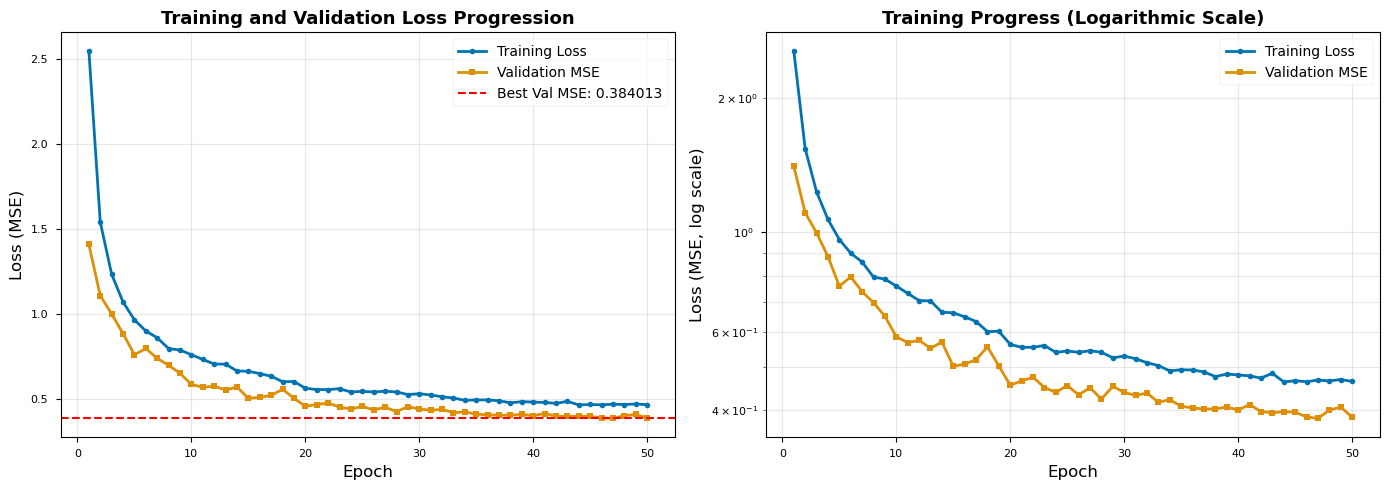


Training Summary
Total epochs completed:       50
Final training loss:          0.464676
Final validation MSE:         0.386598
Best validation MSE:          0.384013
Improvement from first epoch: 72.7%


In [30]:
# Visualize training progress
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

epochs_range = range(1, len(train_losses) + 1)

# Linear scale
axes[0].plot(epochs_range, train_losses, 'o-', linewidth=2, markersize=4, label='Training Loss')
axes[0].plot(epochs_range, val_losses, 's-', linewidth=2, markersize=4, label='Validation MSE')
axes[0].axhline(y=best_val_loss, color='red', linestyle='--', linewidth=1.5,
                label=f'Best Val MSE: {best_val_loss:.6f}')
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Loss (MSE)', fontsize=12)
axes[0].set_title('Training and Validation Loss Progression', fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)

# Log scale
axes[1].plot(epochs_range, train_losses, 'o-', linewidth=2, markersize=4, label='Training Loss')
axes[1].plot(epochs_range, val_losses, 's-', linewidth=2, markersize=4, label='Validation MSE')
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss (MSE, log scale)', fontsize=12)
axes[1].set_title('Training Progress (Logarithmic Scale)', fontsize=13, fontweight='bold')
axes[1].set_yscale('log')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3, which='both')

plt.tight_layout()
plt.show()

print(f"\nTraining Summary")
print("=" * 60)
print(f"Total epochs completed:       {len(train_losses)}")
print(f"Final training loss:          {train_losses[-1]:.6f}")
print(f"Final validation MSE:         {val_losses[-1]:.6f}")
print(f"Best validation MSE:          {best_val_loss:.6f}")
print(f"Improvement from first epoch: {((val_losses[0] - best_val_loss) / val_losses[0] * 100):.1f}%")

## Section 5: Model Evaluation

### Performance Assessment

We evaluate the trained model on the held-out test set to quantify improvement over the RDKit baseline. Performance is assessed globally and stratified by molecular size to identify where the model provides greatest benefit.

In [31]:
# Load best model and evaluate on test set
model.load_state_dict(torch.load(ckpt_path, map_location=device))

test_preds, test_targets, test_baselines, test_mws, test_mol_indices = evaluate(
    model, test_loader, device
)

print("Test Set Evaluation Complete")
print("=" * 60)
print(f"Number of test molecules: {len(test_targets)}")

Test Set Evaluation Complete
Number of test molecules: 2793


In [32]:
# Calculate comprehensive metrics
def calculate_metrics(targets, predictions):
    """Calculate RMSE and MAE."""
    rmse = np.sqrt(mean_squared_error(targets, predictions))
    mae = mean_absolute_error(targets, predictions)
    return rmse, mae

# Overall performance
rmse_baseline_all, mae_baseline_all = calculate_metrics(test_targets, test_baselines)
rmse_model_all, mae_model_all = calculate_metrics(test_targets, test_preds)

# Size-stratified performance
mask_small = test_mws <= MW_CUTOFF
mask_large = test_mws > MW_CUTOFF

print("\nPERFORMANCE COMPARISON")
print("=" * 70)
print(f"{'Metric':<30} | {'RDKit Baseline':<18} | {'Trained Model':<18}")
print("-" * 70)
print(f"{'RMSE':<30} | {rmse_baseline_all:>16.4f} | {rmse_model_all:>16.4f}")
print(f"{'MAE':<30} | {mae_baseline_all:>16.4f} | {mae_model_all:>16.4f}")


# Overall improvement
overall_rmse_improvement = (rmse_baseline_all - rmse_model_all) / rmse_baseline_all * 100
overall_mae_improvement = (mae_baseline_all - mae_model_all) / mae_baseline_all * 100
print(f"\nOverall improvement:")
print(f"  RMSE reduction: {overall_rmse_improvement:.1f}%")
print(f"  MAE reduction:  {overall_mae_improvement:.1f}%")


PERFORMANCE COMPARISON
Metric                         | RDKit Baseline     | Trained Model     
----------------------------------------------------------------------
RMSE                           |           2.0893 |           0.6408
MAE                            |           1.7294 |           0.4721

Overall improvement:
  RMSE reduction: 69.3%
  MAE reduction:  72.7%


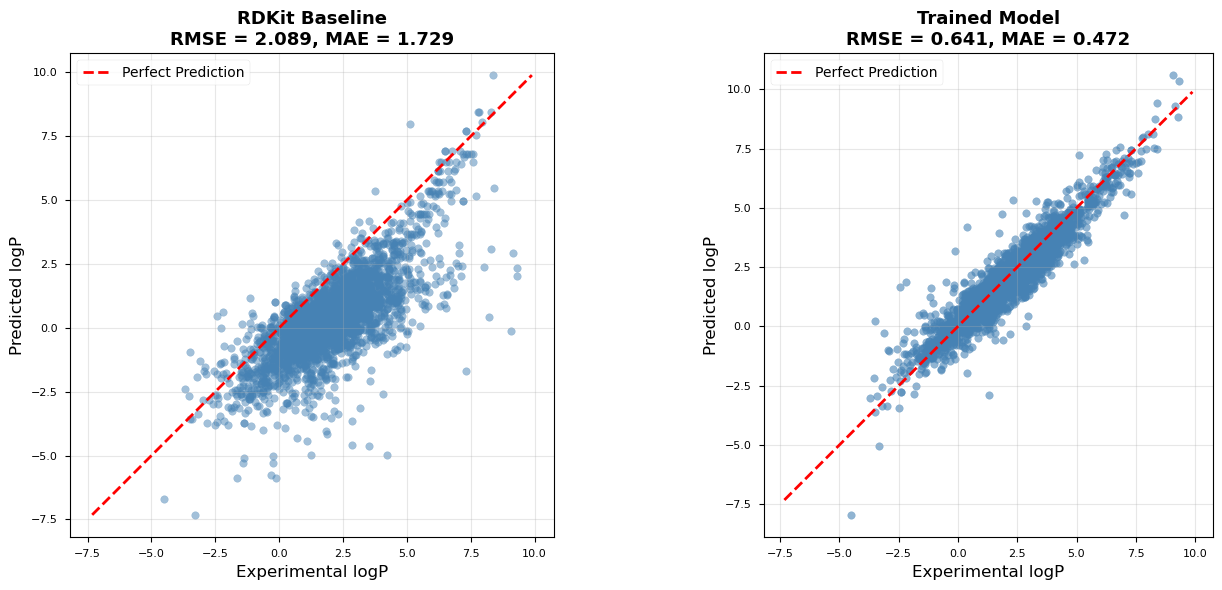

In [33]:
# Prediction scatter plots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Baseline predictions
axes[0].scatter(test_targets, test_baselines, alpha=0.5, s=30, c='steelblue')
min_val = min(test_targets.min(), test_baselines.min())
max_val = max(test_targets.max(), test_baselines.max())
axes[0].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[0].set_xlabel('Experimental logP', fontsize=12)
axes[0].set_ylabel('Predicted logP', fontsize=12)
axes[0].set_title(f'RDKit Baseline\nRMSE = {rmse_baseline_all:.3f}, MAE = {mae_baseline_all:.3f}',
                  fontsize=13, fontweight='bold')
axes[0].legend(fontsize=10)
axes[0].grid(True, alpha=0.3)
axes[0].set_aspect('equal', adjustable='box')

# Model predictions
scatter = axes[1].scatter(test_targets, test_preds, c="steelblue", alpha=0.6, s=30,
                         cmap='viridis', vmin=test_mws.min(), vmax=test_mws.max())
axes[1].plot([min_val, max_val], [min_val, max_val], 'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Experimental logP', fontsize=12)
axes[1].set_ylabel('Predicted logP', fontsize=12)
axes[1].set_title(f'Trained Model\nRMSE = {rmse_model_all:.3f}, MAE = {mae_model_all:.3f}',
                  fontsize=13, fontweight='bold')
axes[1].legend(fontsize=10)
axes[1].grid(True, alpha=0.3)
axes[1].set_aspect('equal', adjustable='box')


plt.tight_layout()
plt.show()

### Performance Interpretation

The trained model demonstrates measurable improvement over the RDKit baseline, particularly for larger molecular structures. The reduction in RMSE and MAE indicates that the learned per-atom scalars successfully correct systematic biases in the Crippen fragmentation method.

The enhanced performance on larger molecules validates our hypothesis that machine learning can capture intramolecular interactions and conformational effects that simple additive models neglect.

## Section 6: Per-Atom Contribution Analysis

### Visualization of Model Corrections

To understand how the model adjusts predictions, we visualize per-atom contributions with color-coding that indicates hydrophobicity shifts relative to the RDKit baseline:

- **Blue atoms**: Model predicts more hydrophilic character (scalar < 1.0)
- **White atoms**: Model agrees with RDKit (scalar ≈ 1.0)
- **Red atoms**: Model predicts more hydrophobic character (scalar > 1.0)

Atom size is proportional to the magnitude of the RDKit baseline contribution, emphasizing atoms with larger influence on the overall logP.

In [34]:
# Import visualization utilities
from src.utils.visualization import (
    visualize_molecule_with_weights,
    visualize_molecule_3d,
    predict_atom_scalars
)

print("Visualization utilities imported successfully.")

Visualization utilities imported successfully.


In [35]:
# Select random test molecules for visualization
np.random.seed(43)
random_indices = np.random.choice(len(test_targets), size=3, replace=False)

print("Selected Molecules for Detailed Analysis")
print("=" * 60)
for i, idx in enumerate(random_indices):
    mol_index = test_mol_indices[idx]
    print(f"\nMolecule {i+1}:")
    print(f"  Dataset index:       {mol_index}")
    print(f"  Molecular weight:    {test_mws[idx]:.1f} Da")
    print(f"  Experimental logP:   {test_targets[idx]:.3f}")
    print(f"  RDKit baseline:      {test_baselines[idx]:.3f} (error: {abs(test_targets[idx] - test_baselines[idx]):.3f})")
    print(f"  Model prediction:    {test_preds[idx]:.3f} (error: {abs(test_targets[idx] - test_preds[idx]):.3f})")

Selected Molecules for Detailed Analysis

Molecule 1:
  Dataset index:       1498
  Molecular weight:    117.2 Da
  Experimental logP:   1.560
  RDKit baseline:      0.892 (error: 0.668)
  Model prediction:    1.962 (error: 0.402)

Molecule 2:
  Dataset index:       5264
  Molecular weight:    252.7 Da
  Experimental logP:   2.970
  RDKit baseline:      1.276 (error: 1.694)
  Model prediction:    3.244 (error: 0.274)

Molecule 3:
  Dataset index:       13547
  Molecular weight:    371.9 Da
  Experimental logP:   4.150
  RDKit baseline:      0.020 (error: 4.130)
  Model prediction:    3.901 (error: 0.249)


### Example Molecule 1: Per-Atom Visualization

The following visualization demonstrates how the model adjusts individual atomic contributions. Atoms colored blue indicate regions where the model reduces predicted lipophilicity relative to RDKit, typically corresponding to polar or charged groups. Red atoms indicate hydrophobic enhancements.

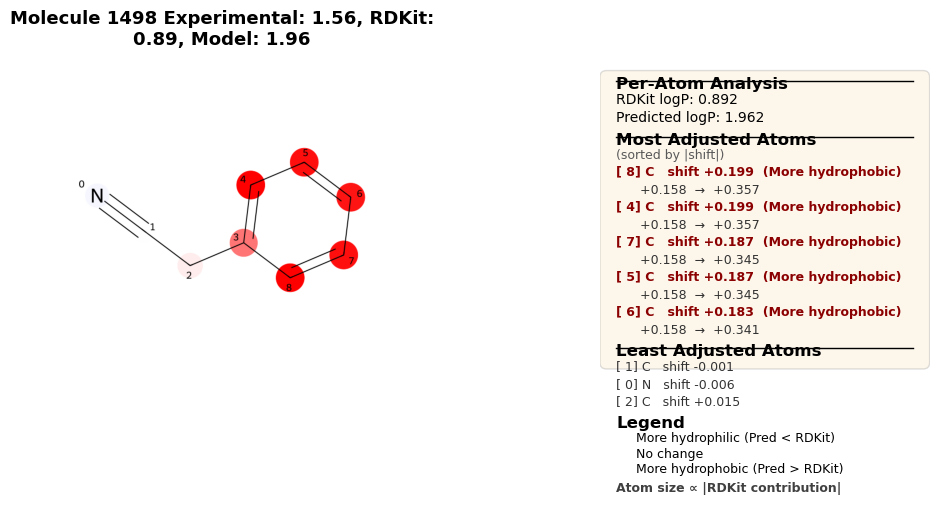

In [36]:
# Visualize first molecule (2D)
mol_index = test_mol_indices[random_indices[0]]
mol_info = mol_data[mol_index]
smiles = mol_info['smiles']
mol = Chem.MolFromSmiles(smiles)

# Predict per-atom scalars
atom_scalars, atom_contribs = predict_atom_scalars(model, mol, device)

title = (f"Molecule {mol_index}\n"
         f"Experimental: {test_targets[random_indices[0]]:.2f}, "
         f"RDKit: {test_baselines[random_indices[0]]:.2f}, "
         f"Model: {test_preds[random_indices[0]]:.2f}")

fig_2d, _ = visualize_molecule_with_weights(
    mol, atom_scalars, atom_contribs,
    title=title, show_3d=False
)
plt.show()

[20:07:05] Molecule does not have explicit Hs. Consider calling AddHs()
[20:07:05] Molecule does not have explicit Hs. Consider calling AddHs()


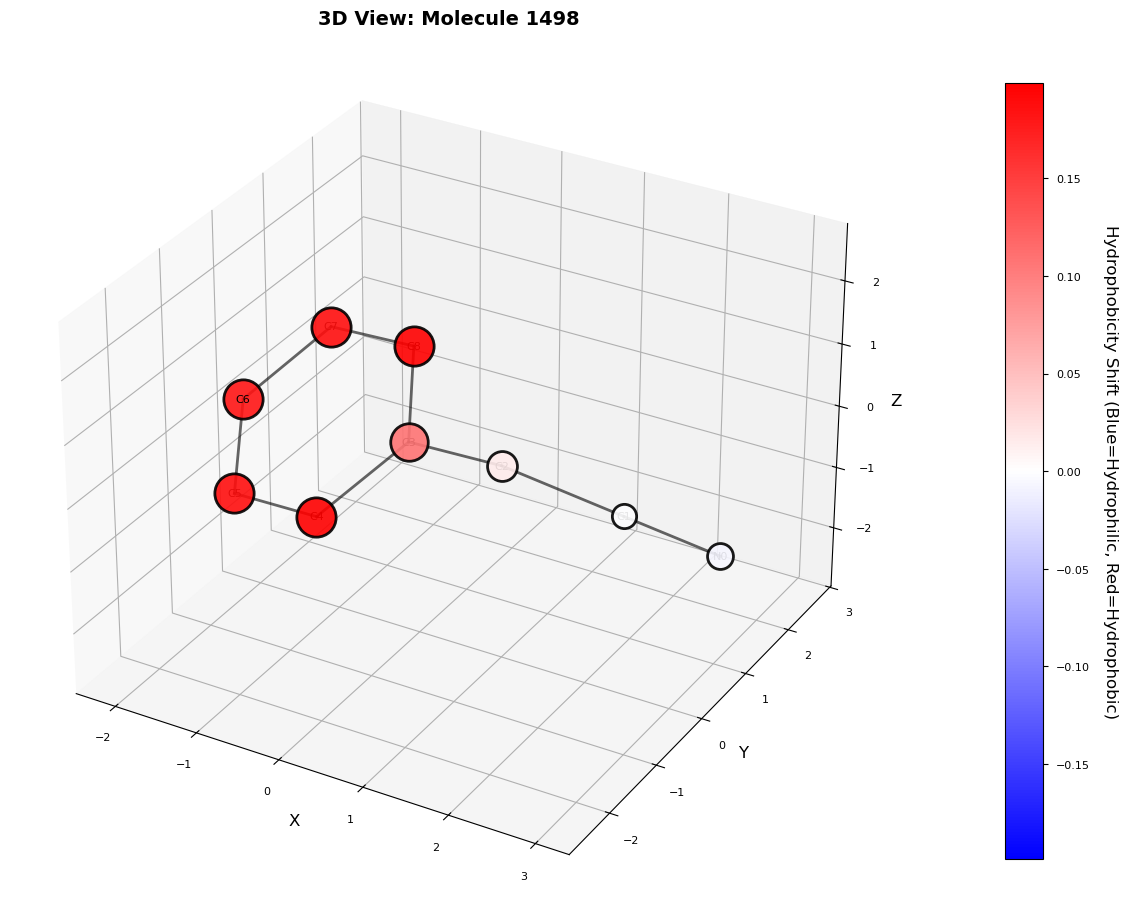

In [37]:
# Visualize first molecule (3D)
fig_3d = visualize_molecule_3d(
    mol, atom_scalars, atom_contribs,
    title=f"3D View: Molecule {mol_index}"
)
plt.show()

### Example Molecule 2: Per-Atom Visualization

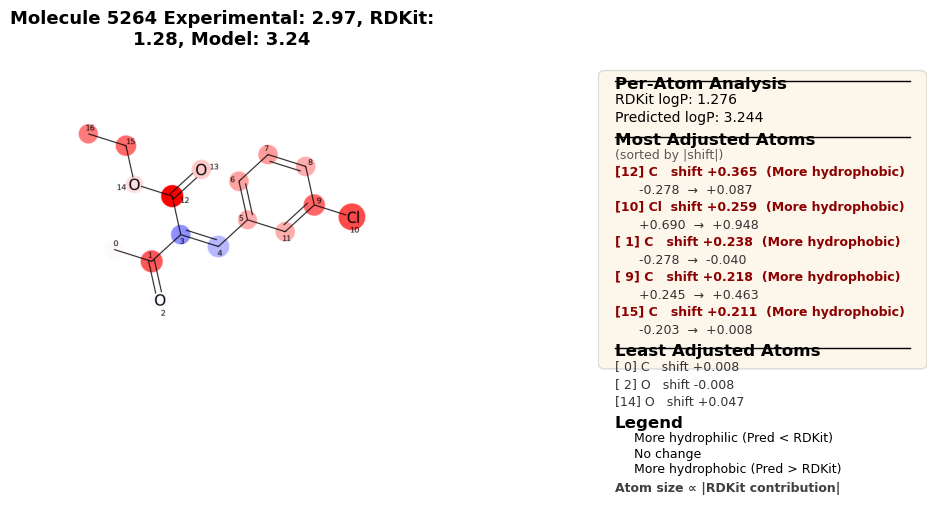

In [38]:
# Visualize second molecule (2D)
mol_index = test_mol_indices[random_indices[1]]
mol_info = mol_data[mol_index]
smiles = mol_info['smiles']
mol = Chem.MolFromSmiles(smiles)

atom_scalars, atom_contribs = predict_atom_scalars(model, mol, device)

title = (f"Molecule {mol_index}\n"
         f"Experimental: {test_targets[random_indices[1]]:.2f}, "
         f"RDKit: {test_baselines[random_indices[1]]:.2f}, "
         f"Model: {test_preds[random_indices[1]]:.2f}")

fig_2d, _ = visualize_molecule_with_weights(
    mol, atom_scalars, atom_contribs,
    title=title, show_3d=False
)
plt.show()

[20:07:19] Molecule does not have explicit Hs. Consider calling AddHs()
[20:07:19] Molecule does not have explicit Hs. Consider calling AddHs()


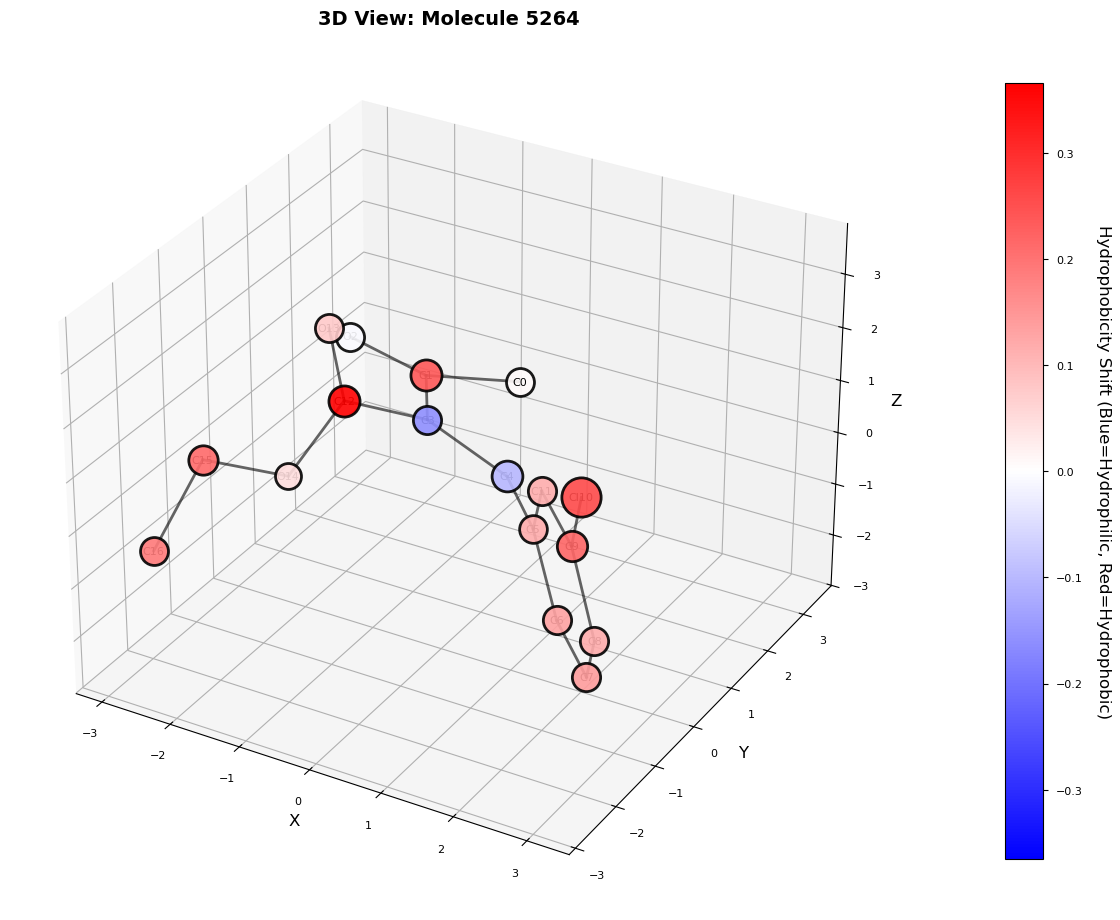

In [39]:
# Visualize second molecule (3D)
fig_3d = visualize_molecule_3d(
    mol, atom_scalars, atom_contribs,
    title=f"3D View: Molecule {mol_index}"
)
plt.show()

### Example Molecule 3: Per-Atom Visualization

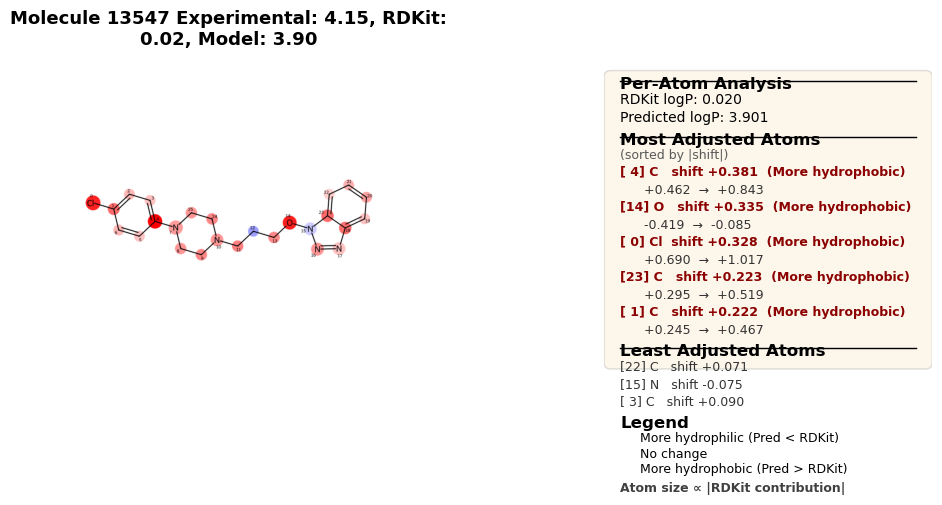

In [40]:
# Visualize third molecule (2D)
mol_index = test_mol_indices[random_indices[2]]
mol_info = mol_data[mol_index]
smiles = mol_info['smiles']
mol = Chem.MolFromSmiles(smiles)

atom_scalars, atom_contribs = predict_atom_scalars(model, mol, device)

title = (f"Molecule {mol_index}\n"
         f"Experimental: {test_targets[random_indices[2]]:.2f}, "
         f"RDKit: {test_baselines[random_indices[2]]:.2f}, "
         f"Model: {test_preds[random_indices[2]]:.2f}")

fig_2d, _ = visualize_molecule_with_weights(
    mol, atom_scalars, atom_contribs,
    title=title, show_3d=False
)
plt.show()

[20:07:26] Molecule does not have explicit Hs. Consider calling AddHs()
[20:07:26] Molecule does not have explicit Hs. Consider calling AddHs()


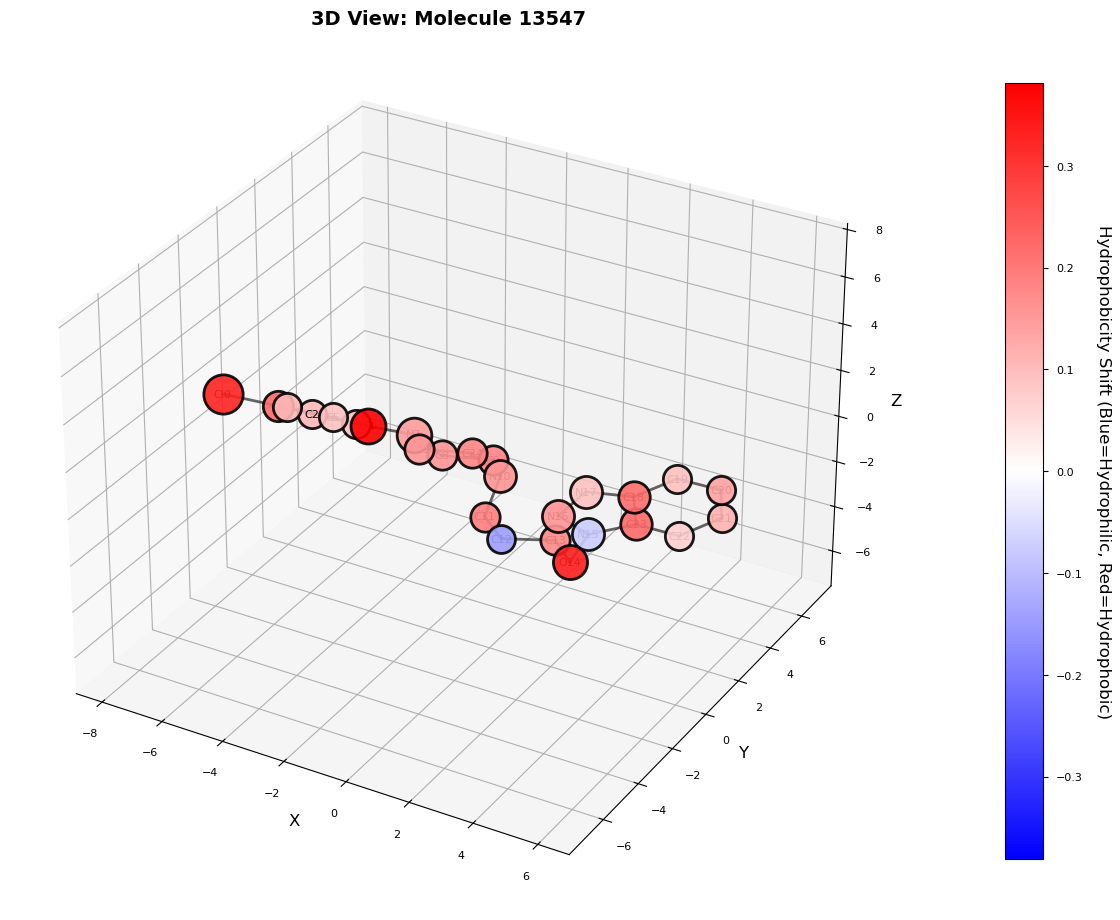

In [41]:
# Visualize third molecule (3D)
fig_3d = visualize_molecule_3d(
    mol, atom_scalars, atom_contribs,
    title=f"3D View: Molecule {mol_index}"
)
plt.show()

### Interactive Exploration

The following function enables exploration of any molecule in the test set. Modify the molecule index to visualize different examples.

Use explore_molecule(index) to visualize any test molecule.
Valid indices: 0 to 2792
Molecule 970: Nc1ccc(CCO)cc1
  Molecular weight:  137.2 Da
  Experimental logP: 0.100
  RDKit baseline:    -0.341
  Model prediction:  0.004


[20:07:31] Molecule does not have explicit Hs. Consider calling AddHs()
[20:07:31] Molecule does not have explicit Hs. Consider calling AddHs()


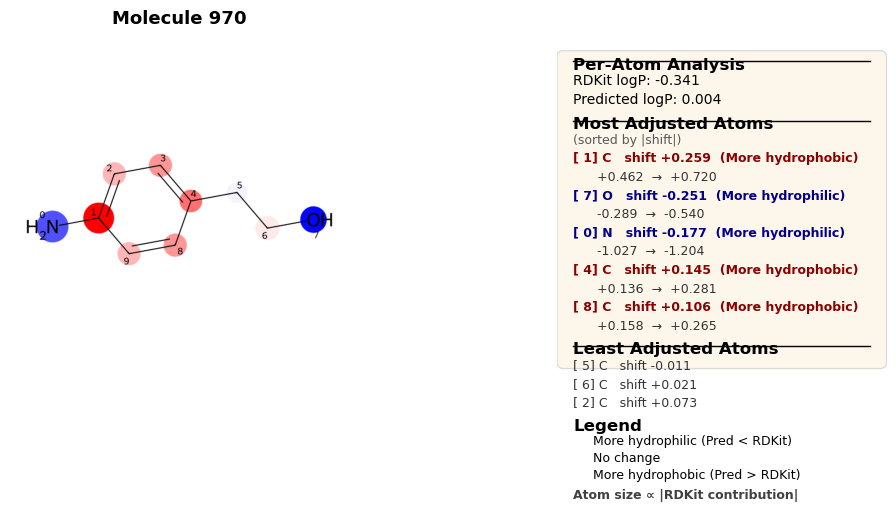

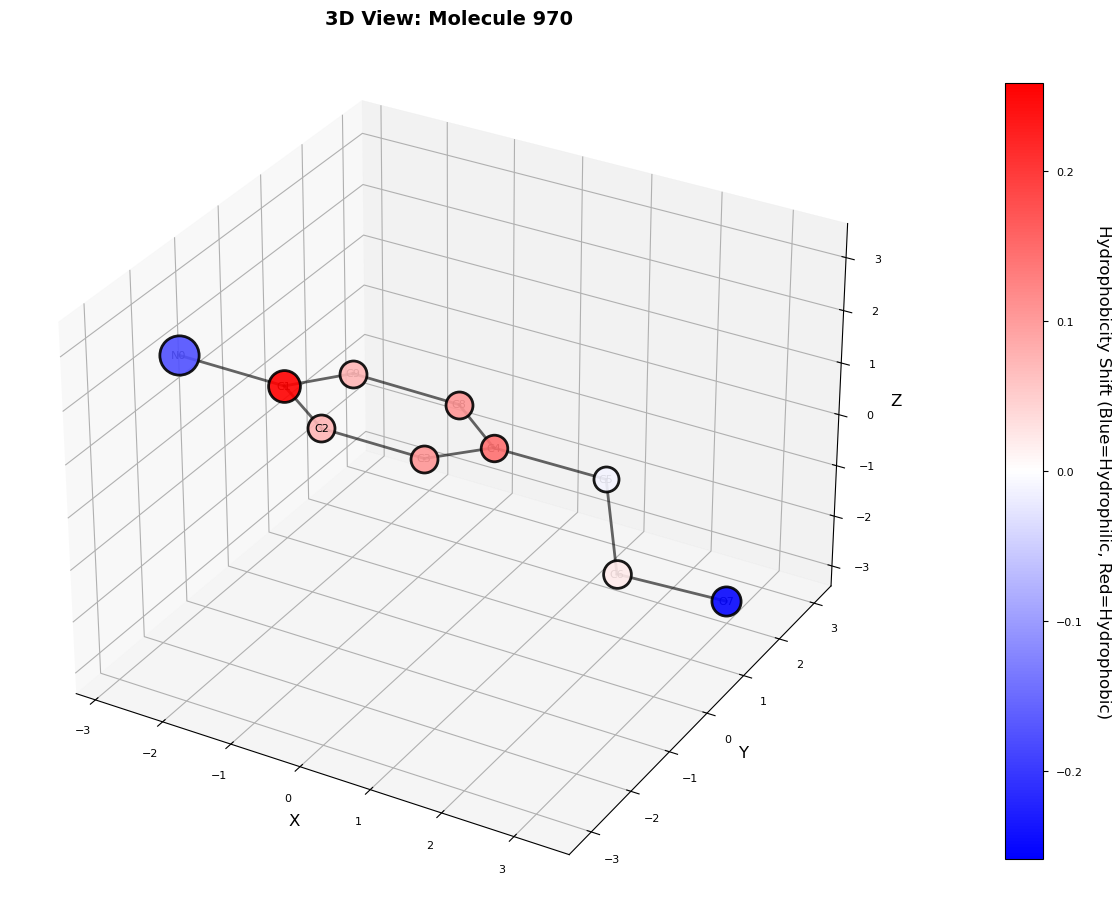

In [42]:
def explore_molecule(mol_idx_in_test_set):
    """
    Interactive function to explore any molecule from the test set.

    Parameters
    ----------
    mol_idx_in_test_set : int
        Index within the test set (0 to len(test_targets)-1)
    """
    if mol_idx_in_test_set < 0 or mol_idx_in_test_set >= len(test_targets):
        print(f"Invalid index. Must be between 0 and {len(test_targets)-1}")
        return

    mol_index = test_mol_indices[mol_idx_in_test_set]
    mol_info = mol_data[mol_index]
    smiles = mol_info['smiles']
    mol = Chem.MolFromSmiles(smiles)

    # Display information
    print(f"Molecule {mol_index}: {smiles}")
    print(f"  Molecular weight:  {test_mws[mol_idx_in_test_set]:.1f} Da")
    print(f"  Experimental logP: {test_targets[mol_idx_in_test_set]:.3f}")
    print(f"  RDKit baseline:    {test_baselines[mol_idx_in_test_set]:.3f}")
    print(f"  Model prediction:  {test_preds[mol_idx_in_test_set]:.3f}")

    # Predict and visualize
    atom_scalars, atom_contribs = predict_atom_scalars(model, mol, device)
    title = f"Molecule {mol_index}"
    visualize_molecule_with_weights(mol, atom_scalars, atom_contribs,
                                     title=title, show_3d=True)

# Example usage (uncomment to use):
# explore_molecule(0)  # Explore first test molecule

print("Use explore_molecule(index) to visualize any test molecule.")
print(f"Valid indices: 0 to {len(test_targets)-1}")

explore_molecule(300)